**Overview (taken from Analytics India Magazine which hosted the competition)**<br>

In this competition, we are challenging the MachineHack community to come up with an algorithm to predict the price of retail items belonging to different categories. Foretelling the Retail price can be a daunting task due to the huge datasets with a variety of attributes ranging from Text, Numbers(floats, integers), and DateTime. Also, outliers can be a big problem when dealing with unit prices.

**Dataset Description:**

* Train.csv - 284780 rows x 8 columns (Inlcudes UnitPrice Columns as Target)
* Test.csv - 122049 rows x 7 columns
 

**Attribute Description:**

* Invoice No - Invoice ID, encoded as Label
* StockCode - Unique code per stock, encoded as Label
* Description - The Description, encoded as Label
* Quantity - Quantity purchased
* InvoiceDate - Date of purchase
* UnitPrice - The target value, price of every product
* CustomerID - Unique Identifier for every Customer
* Country - Country of sales, encoded as Label
 

**Skills:**

* Multivariate Regression
* Big dataset, underfitting vs overfitting
* Optimizing RMSE to generalize well on unseen data

In [96]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from scipy import stats
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import RobustScaler

In [97]:
train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [98]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284780 entries, 0 to 284779
Data columns (total 8 columns):
InvoiceNo      284780 non-null int64
StockCode      284780 non-null int64
Description    284780 non-null int64
Quantity       284780 non-null int64
InvoiceDate    284780 non-null object
UnitPrice      284780 non-null float64
CustomerID     284780 non-null float64
Country        284780 non-null int64
dtypes: float64(2), int64(5), object(1)
memory usage: 17.4+ MB


In [99]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122049 entries, 0 to 122048
Data columns (total 7 columns):
InvoiceNo      122049 non-null int64
StockCode      122049 non-null int64
Description    122049 non-null int64
Quantity       122049 non-null int64
InvoiceDate    122049 non-null object
CustomerID     122049 non-null float64
Country        122049 non-null int64
dtypes: float64(1), int64(5), object(1)
memory usage: 6.5+ MB


In [100]:
train_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35


In [101]:
test_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35


In [102]:
print(train_df.nunique())

InvoiceNo      20971
StockCode       3619
Description     3819
Quantity         373
InvoiceDate    19451
UnitPrice        524
CustomerID      4339
Country           37
dtype: int64


{'whiskers': [<matplotlib.lines.Line2D at 0x1de898f08d0>,
 'caps': [<matplotlib.lines.Line2D at 0x1de898f0fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1de898f0470>],
 'medians': [<matplotlib.lines.Line2D at 0x1deb4410710>],
 'fliers': [<matplotlib.lines.Line2D at 0x1deb4410a90>],
 'means': []}

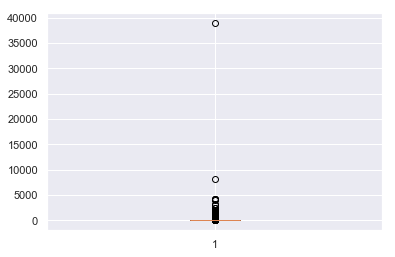

In [103]:
plt.boxplot(train_df.UnitPrice)

**Will Remove one Row containing UnitPrice of ~38000 as it is not likely to repeat**

In [104]:
train_df=train_df[train_df.UnitPrice<30000]

**Date column type is not correct, hence first convert it to date object**

In [105]:
train_df['Inv_date_proper']=pd.to_datetime(train_df['InvoiceDate']).dt.date.astype('datetime64')
train_df['yrmth']=train_df['Inv_date_proper'].dt.strftime("%Y-%m")
test_df['Inv_date_proper']=pd.to_datetime(test_df['InvoiceDate']).dt.date.astype('datetime64')
test_df['yrmth']=test_df['Inv_date_proper'].dt.strftime("%Y-%m")
train_df.info()
train_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284779
Data columns (total 10 columns):
InvoiceNo          284779 non-null int64
StockCode          284779 non-null int64
Description        284779 non-null int64
Quantity           284779 non-null int64
InvoiceDate        284779 non-null object
UnitPrice          284779 non-null float64
CustomerID         284779 non-null float64
Country            284779 non-null int64
Inv_date_proper    284779 non-null datetime64[ns]
yrmth              284779 non-null object
dtypes: datetime64[ns](1), float64(2), int64(5), object(2)
memory usage: 23.9+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Inv_date_proper,yrmth
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35,2011-05-06,2011-05
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35,2011-05-11,2011-05
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35,2011-11-20,2011-11
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35,2011-11-22,2011-11
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35,2011-05-06,2011-05


**Extract useful information from date column**

In [106]:
train_df['hour_of_day']=train_df.Inv_date_proper.dt.hour
train_df['weekday']=train_df.Inv_date_proper.dt.dayofweek
train_df['day_of_month']=train_df.Inv_date_proper.dt.day
train_df['year']=train_df.Inv_date_proper.dt.year
train_df['month']=train_df.Inv_date_proper.dt.month
train_df.head()
train_df.info()
test_df['hour_of_day']=test_df.Inv_date_proper.dt.hour
test_df['weekday']=test_df.Inv_date_proper.dt.dayofweek
test_df['day_of_month']=test_df.Inv_date_proper.dt.day
test_df['year']=test_df.Inv_date_proper.dt.year
test_df['month']=test_df.Inv_date_proper.dt.month

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284779
Data columns (total 15 columns):
InvoiceNo          284779 non-null int64
StockCode          284779 non-null int64
Description        284779 non-null int64
Quantity           284779 non-null int64
InvoiceDate        284779 non-null object
UnitPrice          284779 non-null float64
CustomerID         284779 non-null float64
Country            284779 non-null int64
Inv_date_proper    284779 non-null datetime64[ns]
yrmth              284779 non-null object
hour_of_day        284779 non-null int64
weekday            284779 non-null int64
day_of_month       284779 non-null int64
year               284779 non-null int64
month              284779 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(10), object(2)
memory usage: 34.8+ MB


In [107]:
train_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284779
Data columns (total 15 columns):
InvoiceNo          284779 non-null int64
StockCode          284779 non-null int64
Description        284779 non-null int64
Quantity           284779 non-null int64
InvoiceDate        284779 non-null object
UnitPrice          284779 non-null float64
CustomerID         284779 non-null float64
Country            284779 non-null int64
Inv_date_proper    284779 non-null datetime64[ns]
yrmth              284779 non-null object
hour_of_day        284779 non-null int64
weekday            284779 non-null int64
day_of_month       284779 non-null int64
year               284779 non-null int64
month              284779 non-null int64
dtypes: datetime64[ns](1), float64(2), int64(10), object(2)
memory usage: 34.8+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122049 entries, 0 to 122048
Data columns (total 14 columns):
InvoiceNo          122049 non-null int64
StockCode          12204

In [108]:
display('Originally no of customers in train set are '+str(train_df.CustomerID.nunique()))
display('No of customers also present in test set are ' +str(train_df[train_df.CustomerID.isin(test_df.CustomerID.unique())]['CustomerID'].nunique()))
display('date range in train set is '+ train_df.Inv_date_proper.min().strftime("%Y-%m-%d") + ' and ' + train_df.Inv_date_proper.max().strftime("%Y-%m-%d"))
display('date range in train set is '+ test_df.Inv_date_proper.min().strftime("%Y-%m-%d") + ' and ' + test_df.Inv_date_proper.max().strftime("%Y-%m-%d"))

'Originally no of customers in train set are 4339'

'No of customers also present in test set are 4193'

'date range in train set is 2010-12-01 and 2011-12-09'

'date range in train set is 2010-12-01 and 2011-12-09'

**Looking at data, since same customers are present in both train and test dataset and also the dates are overlapping, we will try to find best guess price depending on the customer, the item and on what day transaction takes place and so on.**

In [109]:
##Get price paid a customer for a stock at a given date and time of the day and match it if same conditions match in test set
same_customer_price1=pd.DataFrame(train_df.groupby(['Country','Quantity','StockCode','CustomerID','Description','InvoiceDate'])['UnitPrice'].mean()).reset_index()
same_customer_price1.head()
same_customer_price1[same_customer_price1.Description==2140]
same_customer_price1.info()
same_customer_price1.columns=['Country','Quantity','StockCode','CustomerID','Description','InvoiceDate','same_customer_same_time_price']
same_customer_price1.info()
train_df=pd.merge(train_df,same_customer_price1,left_on=['Country','Quantity','StockCode','CustomerID','Description','InvoiceDate'],right_on=['Country','Quantity','StockCode','CustomerID','Description','InvoiceDate'],how='left')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282102 entries, 0 to 282101
Data columns (total 7 columns):
Country        282102 non-null int64
Quantity       282102 non-null int64
StockCode      282102 non-null int64
CustomerID     282102 non-null float64
Description    282102 non-null int64
InvoiceDate    282102 non-null object
UnitPrice      282102 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 15.1+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 282102 entries, 0 to 282101
Data columns (total 7 columns):
Country                          282102 non-null int64
Quantity                         282102 non-null int64
StockCode                        282102 non-null int64
CustomerID                       282102 non-null float64
Description                      282102 non-null int64
InvoiceDate                      282102 non-null object
same_customer_same_time_price    282102 non-null float64
dtypes: float64(2), int64(4), object(1)
memory usage: 15.1+ MB


In [110]:
test_df=pd.merge(test_df,same_customer_price1,left_on=['Country','Quantity','StockCode','CustomerID','Description','InvoiceDate'],right_on=['Country','Quantity','StockCode','CustomerID','Description','InvoiceDate'],how='left')
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 15 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(10), o

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,weekday,day_of_month,year,month,same_customer_same_time_price
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22,2011-02,0,1,22,2011,2,NaN
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08,2010-12,0,2,8,2010,12,NaN
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25,2011-10,0,1,25,2011,10,NaN
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27,2011-06,0,0,27,2011,6,NaN
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06,2011-11,0,6,6,2011,11,NaN


In [111]:
##Get price paid a customer for a stock on a given date and match it if same conditions match in test set
same_customer_price2=pd.DataFrame(train_df.groupby(['Country','Quantity','StockCode','CustomerID','Description','Inv_date_proper'])['UnitPrice'].mean()).reset_index()
same_customer_price2.head()
same_customer_price2[same_customer_price2.Description==2140]
same_customer_price2.info()
same_customer_price2.columns=['Country','Quantity','StockCode','CustomerID','Description','Inv_date_proper','same_customer_price']
same_customer_price2.info()
train_df=pd.merge(train_df,same_customer_price2,left_on=['Country','Quantity','StockCode','CustomerID','Description','Inv_date_proper'],right_on=['Country','Quantity','StockCode','CustomerID','Description','Inv_date_proper'],how='left')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281325 entries, 0 to 281324
Data columns (total 7 columns):
Country            281325 non-null int64
Quantity           281325 non-null int64
StockCode          281325 non-null int64
CustomerID         281325 non-null float64
Description        281325 non-null int64
Inv_date_proper    281325 non-null datetime64[ns]
UnitPrice          281325 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 15.0 MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 281325 entries, 0 to 281324
Data columns (total 7 columns):
Country                281325 non-null int64
Quantity               281325 non-null int64
StockCode              281325 non-null int64
CustomerID             281325 non-null float64
Description            281325 non-null int64
Inv_date_proper        281325 non-null datetime64[ns]
same_customer_price    281325 non-null float64
dtypes: datetime64[ns](1), float64(2), int64(4)
memory usage: 15.0 MB
<class 'pand

In [112]:
test_df=pd.merge(test_df,same_customer_price2,left_on=['Country','Quantity','StockCode','CustomerID','Description','Inv_date_proper'],right_on=['Country','Quantity','StockCode','CustomerID','Description','Inv_date_proper'],how='left')
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 16 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,weekday,day_of_month,year,month,same_customer_same_time_price,same_customer_price
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22,2011-02,0,1,22,2011,2,NaN,NaN
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08,2010-12,0,2,8,2010,12,NaN,NaN
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25,2011-10,0,1,25,2011,10,NaN,NaN
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27,2011-06,0,0,27,2011,6,NaN,NaN
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06,2011-11,0,6,6,2011,11,NaN,NaN


In [113]:
##Get price paid by any customer for a stock on a given date and match it if same conditions match in test set
same_day_price=pd.DataFrame(train_df.groupby(['Country','Quantity','StockCode','Description','Inv_date_proper'])['UnitPrice'].mean()).reset_index()
same_day_price.head()
# same_day_price.info()
same_day_price.columns=['Country','Quantity','StockCode','Description','Inv_date_proper','same_day_price']
same_day_price.info()
train_df=pd.merge(train_df,same_day_price,left_on=['Country','Quantity','StockCode','Description','Inv_date_proper'],right_on=['Country','Quantity','StockCode','Description','Inv_date_proper'],how='left')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253203 entries, 0 to 253202
Data columns (total 6 columns):
Country            253203 non-null int64
Quantity           253203 non-null int64
StockCode          253203 non-null int64
Description        253203 non-null int64
Inv_date_proper    253203 non-null datetime64[ns]
same_day_price     253203 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(4)
memory usage: 11.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284778
Data columns (total 18 columns):
InvoiceNo                        284779 non-null int64
StockCode                        284779 non-null int64
Description                      284779 non-null int64
Quantity                         284779 non-null int64
InvoiceDate                      284779 non-null object
UnitPrice                        284779 non-null float64
CustomerID                       284779 non-null float64
Country                          284779 non-null int64
Inv_dat

In [114]:
test_df=pd.merge(test_df,same_day_price,left_on=['Country','Quantity','StockCode','Description','Inv_date_proper'],right_on=['Country','Quantity','StockCode','Description','Inv_date_proper'],how='left')
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 17 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,weekday,day_of_month,year,month,same_customer_same_time_price,same_customer_price,same_day_price
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22,2011-02,0,1,22,2011,2,NaN,NaN,NaN
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08,2010-12,0,2,8,2010,12,NaN,NaN,NaN
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25,2011-10,0,1,25,2011,10,NaN,NaN,NaN
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27,2011-06,0,0,27,2011,6,NaN,NaN,NaN
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06,2011-11,0,6,6,2011,11,NaN,NaN,NaN


In [115]:
##Get price paid by any customer for a stock in a given month and match it if same conditions match in test set
same_month_price=pd.DataFrame(train_df.groupby(['Country','Quantity','StockCode','Description','yrmth'])['UnitPrice'].mean()).reset_index()
same_month_price.head()
# same_day_price.info()
same_month_price.columns=['Country','Quantity','StockCode','Description','yrmth','same_month_price']
same_month_price.info()
train_df=pd.merge(train_df,same_month_price,left_on=['Country','Quantity','StockCode','Description','yrmth'],right_on=['Country','Quantity','StockCode','Description','yrmth'],how='left')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127507 entries, 0 to 127506
Data columns (total 6 columns):
Country             127507 non-null int64
Quantity            127507 non-null int64
StockCode           127507 non-null int64
Description         127507 non-null int64
yrmth               127507 non-null object
same_month_price    127507 non-null float64
dtypes: float64(1), int64(4), object(1)
memory usage: 5.8+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284778
Data columns (total 19 columns):
InvoiceNo                        284779 non-null int64
StockCode                        284779 non-null int64
Description                      284779 non-null int64
Quantity                         284779 non-null int64
InvoiceDate                      284779 non-null object
UnitPrice                        284779 non-null float64
CustomerID                       284779 non-null float64
Country                          284779 non-null int64
Inv_date_proper  

In [116]:
test_df=pd.merge(test_df,same_month_price,left_on=['Country','Quantity','StockCode','Description','yrmth'],right_on=['Country','Quantity','StockCode','Description','yrmth'],how='left')
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 18 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,weekday,day_of_month,year,month,same_customer_same_time_price,same_customer_price,same_day_price,same_month_price
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22,2011-02,0,1,22,2011,2,NaN,NaN,NaN,NaN
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08,2010-12,0,2,8,2010,12,NaN,NaN,NaN,1.25
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25,2011-10,0,1,25,2011,10,NaN,NaN,NaN,NaN
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27,2011-06,0,0,27,2011,6,NaN,NaN,NaN,1.65
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06,2011-11,0,6,6,2011,11,NaN,NaN,NaN,12.75


In [117]:
##Get price paid by any customer for a stock on a given date and match it if same conditions match in test set
same_year_price=pd.DataFrame(train_df.groupby(['Country','Quantity','StockCode','Description','year'])['UnitPrice'].mean()).reset_index()
same_year_price.head()
# same_day_price.info()
same_year_price.columns=['Country','Quantity','StockCode','Description','year','same_year_price']
same_year_price.info()
train_df=pd.merge(train_df,same_year_price,left_on=['Country','Quantity','StockCode','Description','year'],right_on=['Country','Quantity','StockCode','Description','year'],how='left')
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56681 entries, 0 to 56680
Data columns (total 6 columns):
Country            56681 non-null int64
Quantity           56681 non-null int64
StockCode          56681 non-null int64
Description        56681 non-null int64
year               56681 non-null int64
same_year_price    56681 non-null float64
dtypes: float64(1), int64(5)
memory usage: 2.6 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284778
Data columns (total 20 columns):
InvoiceNo                        284779 non-null int64
StockCode                        284779 non-null int64
Description                      284779 non-null int64
Quantity                         284779 non-null int64
InvoiceDate                      284779 non-null object
UnitPrice                        284779 non-null float64
CustomerID                       284779 non-null float64
Country                          284779 non-null int64
Inv_date_proper                  284779 non-

In [118]:
test_df=pd.merge(test_df,same_year_price,left_on=['Country','Quantity','StockCode','Description','year'],right_on=['Country','Quantity','StockCode','Description','year'],how='left')
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 19 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,weekday,day_of_month,year,month,same_customer_same_time_price,same_customer_price,same_day_price,same_month_price,same_year_price
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22,2011-02,0,1,22,2011,2,NaN,NaN,NaN,NaN,NaN
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08,2010-12,0,2,8,2010,12,NaN,NaN,NaN,1.25,1.250000
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25,2011-10,0,1,25,2011,10,NaN,NaN,NaN,NaN,3.616667
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27,2011-06,0,0,27,2011,6,NaN,NaN,NaN,1.65,1.645897
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06,2011-11,0,6,6,2011,11,NaN,NaN,NaN,12.75,12.968036


**Next, create a feature 'best guess price' with filling values in order we created them giving priority to the same customer same time price**

In [119]:
test_df['best_guess_price']=test_df['same_customer_same_time_price']
test_df['best_guess_price'].fillna(test_df['same_customer_price'],inplace=True)
test_df['best_guess_price'].fillna(test_df['same_day_price'],inplace=True)
test_df['best_guess_price'].fillna(test_df['same_month_price'],inplace=True)
test_df['best_guess_price'].fillna(test_df['same_month_price'],inplace=True)
test_df['best_guess_price'].fillna(test_df['same_year_price'],inplace=True)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 20 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

In [120]:
##to fill NA get any day price of the stock present in train set
any_day_price=pd.DataFrame(train_df.groupby(['Country','Quantity','StockCode','Description'])['UnitPrice'].mean()).reset_index()
any_day_price.info()
any_day_price.columns=['Country','Quantity','StockCode','Description','any_day_price']
test_df=pd.merge(test_df,any_day_price,left_on=['Country','Quantity','StockCode','Description'],right_on=['Country','Quantity','StockCode','Description'],how='left')
# test_df['same_day_price']= np.where(test_df['same_day_price'].isnull(),test_df['StockCode'].map(any_day_price.set_index(['StockCode'])['UnitPrice']),test_df['same_day_price'])
# test_df.info()
test_df['best_guess_price'].fillna(test_df['any_day_price'],inplace=True)
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49711 entries, 0 to 49710
Data columns (total 5 columns):
Country        49711 non-null int64
Quantity       49711 non-null int64
StockCode      49711 non-null int64
Description    49711 non-null int64
UnitPrice      49711 non-null float64
dtypes: float64(1), int64(4)
memory usage: 1.9 MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 21 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 n

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,...,day_of_month,year,month,same_customer_same_time_price,same_customer_price,same_day_price,same_month_price,same_year_price,best_guess_price,any_day_price
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22,2011-02,0,...,22,2011,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08,2010-12,0,...,8,2010,12,NaN,NaN,NaN,1.25,1.250000,1.250000,1.280833
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25,2011-10,0,...,25,2011,10,NaN,NaN,NaN,NaN,3.616667,3.616667,3.394444
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27,2011-06,0,...,27,2011,6,NaN,NaN,NaN,1.65,1.645897,1.650000,1.636341
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06,2011-11,0,...,6,2011,11,NaN,NaN,NaN,12.75,12.968036,12.750000,12.964211


In [121]:
#Still not all values are filled in the feature hence get a stock price irrespective of country, description and impute it in the test set
stock_past_price=pd.DataFrame(train_df.groupby('StockCode')['UnitPrice'].mean()).reset_index()
stock_past_price.head()
test_df['best_guess_price']= np.where(test_df['best_guess_price'].isnull(),test_df['StockCode'].map(stock_past_price.set_index(['StockCode'])['UnitPrice']),test_df['best_guess_price'])
test_df.info()
test_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 21 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,...,day_of_month,year,month,same_customer_same_time_price,same_customer_price,same_day_price,same_month_price,same_year_price,best_guess_price,any_day_price
0,3139,1709,1079,3,2011-02-22 15:22:00,16161.0,35,2011-02-22,2011-02,0,...,22,2011,2,NaN,NaN,NaN,NaN,NaN,1.650000,NaN
1,617,510,3457,1,2010-12-08 12:46:00,17341.0,35,2010-12-08,2010-12,0,...,8,2010,12,NaN,NaN,NaN,1.25,1.250000,1.250000,1.280833
2,14653,604,694,36,2011-10-25 13:53:00,15158.0,35,2011-10-25,2011-10,0,...,25,2011,10,NaN,NaN,NaN,NaN,3.616667,3.616667,3.394444
3,8634,1478,3473,2,2011-06-27 12:38:00,16033.0,35,2011-06-27,2011-06,0,...,27,2011,6,NaN,NaN,NaN,1.65,1.645897,1.650000,1.636341
4,15546,3216,871,1,2011-11-06 16:14:00,15351.0,35,2011-11-06,2011-11,0,...,6,2011,11,NaN,NaN,NaN,12.75,12.968036,12.750000,12.964211


In [122]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284778
Data columns (total 20 columns):
InvoiceNo                        284779 non-null int64
StockCode                        284779 non-null int64
Description                      284779 non-null int64
Quantity                         284779 non-null int64
InvoiceDate                      284779 non-null object
UnitPrice                        284779 non-null float64
CustomerID                       284779 non-null float64
Country                          284779 non-null int64
Inv_date_proper                  284779 non-null datetime64[ns]
yrmth                            284779 non-null object
hour_of_day                      284779 non-null int64
weekday                          284779 non-null int64
day_of_month                     284779 non-null int64
year                             284779 non-null int64
month                            284779 non-null int64
same_customer_same_time_price    284779 non-null 

**Create same feature in train set using same customer same time price since we have all values in train set**

In [123]:
train_df['best_guess_price']=train_df['same_customer_same_time_price']

**Next, change the labels of Description, StockCode, Customer and Country using ranks according to their average unit price in train set**

In [124]:
# temp=pd.DataFrame(train_df.groupby(['StockCode','Country','Quantity','Description'])['UnitPrice'].agg(lambda x:x.value_counts().index[0]))
temp=pd.DataFrame(train_df.groupby(['Description'])['UnitPrice'].agg(lambda x:x.value_counts().index[0]))
temp=temp.reset_index()
print(len(temp))
temp['desc_code']=temp['UnitPrice'].rank(method='min')
print(len(temp))
desc_df=temp.copy()
df=pd.merge(train_df,temp[['Description','desc_code']],left_on=['Description'],right_on=['Description'],how='left')
print(df.head())
print(df.info())

3819
3819
   InvoiceNo  StockCode  Description  Quantity          InvoiceDate  \
0       6141       1583          144         3  2011-05-06 16:54:00   
1       6349       1300         3682         6  2011-05-11 07:35:00   
2      16783       2178         1939         4  2011-11-20 13:20:00   
3      16971       2115         2983         1  2011-11-22 12:07:00   
4       6080       1210         2886        12  2011-05-06 09:00:00   

   UnitPrice  CustomerID  Country Inv_date_proper    yrmth  ...  day_of_month  \
0       3.75     14056.0       35      2011-05-06  2011-05  ...             6   
1       1.95     13098.0       35      2011-05-11  2011-05  ...            11   
2       5.95     15044.0       35      2011-11-20  2011-11  ...            20   
3       0.83     15525.0       35      2011-11-22  2011-11  ...            22   
4       1.65     13952.0       35      2011-05-06  2011-05  ...             6   

   year  month  same_customer_same_time_price  same_customer_price  \
0  201

In [125]:
test_df1=pd.merge(test_df,desc_df[['Description','desc_code']],left_on=['Description'],right_on=['Description'],how='left')

test_df1.info()

test_df1[test_df1.desc_code.isnull()]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 22 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,...,year,month,same_customer_same_time_price,same_customer_price,same_day_price,same_month_price,same_year_price,best_guess_price,any_day_price,desc_code
1565,17251,3516,3738,1,2011-11-24 14:40:00,17364.0,35,2011-11-24,2011-11,0,...,2011,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3056,1998,825,1403,2,2011-01-20 15:22:00,15498.0,35,2011-01-20,2011-01,0,...,2011,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5492,926,3463,2574,2,2010-12-13 14:16:00,17231.0,35,2010-12-13,2010-12,0,...,2010,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7567,307,2932,2434,2,2010-12-03 15:45:00,12725.0,18,2010-12-03,2010-12,0,...,2010,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8592,19709,3049,3296,-1,2011-04-14 10:29:00,15299.0,35,2011-04-14,2011-04,0,...,2011,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11440,3144,558,2927,1,2011-02-22 16:13:00,18196.0,35,2011-02-22,2011-02,0,...,2011,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11773,8654,1863,1442,8,2011-06-28 08:50:00,14646.0,23,2011-06-28,2011-06,0,...,2011,6,NaN,NaN,NaN,NaN,NaN,12.385593,NaN,NaN
12031,7870,3033,931,1,2011-06-09 16:16:00,15058.0,35,2011-06-09,2011-06,0,...,2011,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12414,1073,3446,1232,1,2010-12-15 13:24:00,13221.0,35,2010-12-15,2010-12,0,...,2010,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13962,3136,717,1389,1,2011-02-22 15:00:00,16907.0,35,2011-02-22,2011-02,0,...,2011,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
temp=pd.DataFrame(train_df.groupby(['StockCode'])['UnitPrice'].agg(lambda x:x.value_counts().index[0]))
temp=temp.reset_index()
temp=temp.sort_values('UnitPrice')

len(temp)
temp['stock_code']=temp.UnitPrice.rank(method='min')
print(temp.head())
temp.info()
stock_df=temp.copy()
df=pd.merge(df,temp[['StockCode','stock_code']],left_on=['StockCode'],right_on=['StockCode'],how='left')
print(df.head())
print(df.info())


      StockCode  UnitPrice  stock_code
3617       3682      0.001         1.0
3614       3679      0.010         2.0
35           35      0.040         3.0
61           63      0.060         4.0
62           64      0.060         4.0
<class 'pandas.core.frame.DataFrame'>
Int64Index: 3619 entries, 3617 to 3613
Data columns (total 3 columns):
StockCode     3619 non-null int64
UnitPrice     3619 non-null float64
stock_code    3619 non-null float64
dtypes: float64(2), int64(1)
memory usage: 113.1 KB
   InvoiceNo  StockCode  Description  Quantity          InvoiceDate  \
0       6141       1583          144         3  2011-05-06 16:54:00   
1       6349       1300         3682         6  2011-05-11 07:35:00   
2      16783       2178         1939         4  2011-11-20 13:20:00   
3      16971       2115         2983         1  2011-11-22 12:07:00   
4       6080       1210         2886        12  2011-05-06 09:00:00   

   UnitPrice  CustomerID  Country Inv_date_proper    yrmth  ...  year  m

In [127]:
test_df1=pd.merge(test_df1,stock_df[['StockCode','stock_code']],left_on=['StockCode'],right_on=['StockCode'],how='left')

test_df1.info()

test_df1[test_df1.desc_code.isnull()]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 23 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,CustomerID,Country,Inv_date_proper,yrmth,hour_of_day,...,month,same_customer_same_time_price,same_customer_price,same_day_price,same_month_price,same_year_price,best_guess_price,any_day_price,desc_code,stock_code
1565,17251,3516,3738,1,2011-11-24 14:40:00,17364.0,35,2011-11-24,2011-11,0,...,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3056,1998,825,1403,2,2011-01-20 15:22:00,15498.0,35,2011-01-20,2011-01,0,...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5492,926,3463,2574,2,2010-12-13 14:16:00,17231.0,35,2010-12-13,2010-12,0,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7567,307,2932,2434,2,2010-12-03 15:45:00,12725.0,18,2010-12-03,2010-12,0,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8592,19709,3049,3296,-1,2011-04-14 10:29:00,15299.0,35,2011-04-14,2011-04,0,...,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11440,3144,558,2927,1,2011-02-22 16:13:00,18196.0,35,2011-02-22,2011-02,0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11773,8654,1863,1442,8,2011-06-28 08:50:00,14646.0,23,2011-06-28,2011-06,0,...,6,NaN,NaN,NaN,NaN,NaN,12.385593,NaN,NaN,3486.0
12031,7870,3033,931,1,2011-06-09 16:16:00,15058.0,35,2011-06-09,2011-06,0,...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12414,1073,3446,1232,1,2010-12-15 13:24:00,13221.0,35,2010-12-15,2010-12,0,...,12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13962,3136,717,1389,1,2011-02-22 15:00:00,16907.0,35,2011-02-22,2011-02,0,...,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [128]:
temp=pd.DataFrame(train_df.groupby(['CustomerID'])['UnitPrice'].agg(lambda x:x.value_counts().index[0]))
temp=temp.reset_index()
temp=temp.sort_values('UnitPrice')
len(temp)
temp['cust_code']=temp['UnitPrice'].rank(method='min')
customer_df=temp.copy()
df=pd.merge(df,temp[['CustomerID','cust_code']],left_on=['CustomerID'],right_on=['CustomerID'],how='left')
print(df.head())
print(df.info())

   InvoiceNo  StockCode  Description  Quantity          InvoiceDate  \
0       6141       1583          144         3  2011-05-06 16:54:00   
1       6349       1300         3682         6  2011-05-11 07:35:00   
2      16783       2178         1939         4  2011-11-20 13:20:00   
3      16971       2115         2983         1  2011-11-22 12:07:00   
4       6080       1210         2886        12  2011-05-06 09:00:00   

   UnitPrice  CustomerID  Country Inv_date_proper    yrmth  ...  month  \
0       3.75     14056.0       35      2011-05-06  2011-05  ...      5   
1       1.95     13098.0       35      2011-05-11  2011-05  ...      5   
2       5.95     15044.0       35      2011-11-20  2011-11  ...     11   
3       0.83     15525.0       35      2011-11-22  2011-11  ...     11   
4       1.65     13952.0       35      2011-05-06  2011-05  ...      5   

   same_customer_same_time_price  same_customer_price  same_day_price  \
0                           3.75                 3.75  

In [129]:
test_df1=pd.merge(test_df1,customer_df[['CustomerID','cust_code']],left_on=['CustomerID'],right_on=['CustomerID'],how='left')

test_df1.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 24 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

In [130]:
#replace NaN with most frequent value
test_df1['desc_code'].fillna(value=test_df1['desc_code'].agg(lambda x:x.value_counts().index[0]), inplace=True)
test_df1['stock_code'].fillna(value=test_df1['stock_code'].agg(lambda x:x.value_counts().index[0]), inplace=True)
test_df1['cust_code'].fillna(value=test_df1['cust_code'].agg(lambda x:x.value_counts().index[0]), inplace=True)
test_df1['best_guess_price'].fillna(value=test_df1['best_guess_price'].agg(lambda x:x.value_counts().index[0]), inplace=True)

In [131]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Inv_date_proper,yrmth,...,month,same_customer_same_time_price,same_customer_price,same_day_price,same_month_price,same_year_price,best_guess_price,desc_code,stock_code,cust_code
0,6141,1583,144,3,2011-05-06 16:54:00,3.75,14056.0,35,2011-05-06,2011-05,...,5,3.75,3.75,3.75,3.75,3.75,3.75,2675.0,2559.0,1972.0
1,6349,1300,3682,6,2011-05-11 07:35:00,1.95,13098.0,35,2011-05-11,2011-05,...,5,1.95,1.95,1.95,1.95,1.95,1.95,1838.0,1765.0,1972.0
2,16783,2178,1939,4,2011-11-20 13:20:00,5.95,15044.0,35,2011-11-20,2011-11,...,11,5.95,5.95,5.95,5.95,5.95,5.95,3244.0,3077.0,3103.0
3,16971,2115,2983,1,2011-11-22 12:07:00,0.83,15525.0,35,2011-11-22,2011-11,...,11,0.83,0.83,0.83,0.83,0.83,0.83,694.0,675.0,862.0
4,6080,1210,2886,12,2011-05-06 09:00:00,1.65,13952.0,35,2011-05-06,2011-05,...,5,1.65,1.65,1.65,1.65,1.65,1.65,1581.0,1523.0,3103.0


In [132]:
test_df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 24 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

In [133]:
test_df=test_df1.copy()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 24 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

In [134]:

temp=pd.DataFrame(train_df.groupby(['Country'])['UnitPrice'].agg(lambda x:x.value_counts().index[0]))
temp=temp.reset_index()
temp=temp.sort_values('UnitPrice')
len(temp)
temp['country_code']=temp['UnitPrice']
print(temp.head())
temp.info()
country_df=temp.copy()
df=pd.merge(df,temp[['Country','country_code']],left_on=['Country'],right_on=['Country'],how='left')
print(df.head())
print(df.info())

    Country  UnitPrice  country_code
31       31       0.42          0.42
9         9       0.42          0.42
36       36       1.25          1.25
19       19       1.25          1.25
35       35       1.25          1.25
<class 'pandas.core.frame.DataFrame'>
Int64Index: 37 entries, 31 to 20
Data columns (total 3 columns):
Country         37 non-null int64
UnitPrice       37 non-null float64
country_code    37 non-null float64
dtypes: float64(2), int64(1)
memory usage: 1.2 KB
   InvoiceNo  StockCode  Description  Quantity          InvoiceDate  \
0       6141       1583          144         3  2011-05-06 16:54:00   
1       6349       1300         3682         6  2011-05-11 07:35:00   
2      16783       2178         1939         4  2011-11-20 13:20:00   
3      16971       2115         2983         1  2011-11-22 12:07:00   
4       6080       1210         2886        12  2011-05-06 09:00:00   

   UnitPrice  CustomerID  Country Inv_date_proper    yrmth  ...  \
0       3.75     14056.0 

In [135]:
test_df=pd.merge(test_df,country_df[['Country','country_code']],left_on=['Country'],right_on=['Country'],how='left')
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 25 columns):
InvoiceNo                        122049 non-null int64
StockCode                        122049 non-null int64
Description                      122049 non-null int64
Quantity                         122049 non-null int64
InvoiceDate                      122049 non-null object
CustomerID                       122049 non-null float64
Country                          122049 non-null int64
Inv_date_proper                  122049 non-null datetime64[ns]
yrmth                            122049 non-null object
hour_of_day                      122049 non-null int64
weekday                          122049 non-null int64
day_of_month                     122049 non-null int64
year                             122049 non-null int64
month                            122049 non-null int64
same_customer_same_time_price    2224 non-null float64
same_customer_price              2824 non-null floa

**Drop columns not required for modelling**

In [136]:
df=df.drop(columns=['Inv_date_proper','InvoiceNo','InvoiceDate','Country','Description','StockCode','CustomerID','same_day_price','same_month_price','same_year_price','yrmth','same_customer_same_time_price','same_customer_price'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284778
Data columns (total 12 columns):
Quantity            284779 non-null int64
UnitPrice           284779 non-null float64
hour_of_day         284779 non-null int64
weekday             284779 non-null int64
day_of_month        284779 non-null int64
year                284779 non-null int64
month               284779 non-null int64
best_guess_price    284779 non-null float64
desc_code           284779 non-null float64
stock_code          284779 non-null float64
cust_code           284779 non-null float64
country_code        284779 non-null float64
dtypes: float64(6), int64(6)
memory usage: 28.2 MB


In [137]:
df=df.drop(columns=['day_of_month'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284778
Data columns (total 11 columns):
Quantity            284779 non-null int64
UnitPrice           284779 non-null float64
hour_of_day         284779 non-null int64
weekday             284779 non-null int64
year                284779 non-null int64
month               284779 non-null int64
best_guess_price    284779 non-null float64
desc_code           284779 non-null float64
stock_code          284779 non-null float64
cust_code           284779 non-null float64
country_code        284779 non-null float64
dtypes: float64(6), int64(5)
memory usage: 26.1 MB


In [138]:
test_final=test_df.drop(columns=['Inv_date_proper','InvoiceNo','InvoiceDate','day_of_month','Country','Description','StockCode','CustomerID','same_day_price','same_month_price','same_year_price','yrmth','any_day_price','same_customer_same_time_price','same_customer_price'])
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 10 columns):
Quantity            122049 non-null int64
hour_of_day         122049 non-null int64
weekday             122049 non-null int64
year                122049 non-null int64
month               122049 non-null int64
best_guess_price    122049 non-null float64
desc_code           122049 non-null float64
stock_code          122049 non-null float64
cust_code           122049 non-null float64
country_code        122049 non-null float64
dtypes: float64(5), int64(5)
memory usage: 10.2 MB


In [139]:
# df_final=pd.get_dummies(df,columns=['Stock_quantile','Desc_quantile','country_code','hour_of_day','weekday','year','month'],drop_first=True)
df_final=df
df_final.info()
# label_cols=['Desc_quantile','Stock_quantile','country_code']
# label_encoder=preprocessing.LabelEncoder()
# df_final['Desc_quantile']=label_encoder.fit_transform(df_final['Desc_quantile'])
# df_final['Stock_quantile']=label_encoder.fit_transform(df_final['Stock_quantile'])
# df_final['country_code']=label_encoder.fit_transform(df_final['Stock_quantile'])
# df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 284779 entries, 0 to 284778
Data columns (total 11 columns):
Quantity            284779 non-null int64
UnitPrice           284779 non-null float64
hour_of_day         284779 non-null int64
weekday             284779 non-null int64
year                284779 non-null int64
month               284779 non-null int64
best_guess_price    284779 non-null float64
desc_code           284779 non-null float64
stock_code          284779 non-null float64
cust_code           284779 non-null float64
country_code        284779 non-null float64
dtypes: float64(6), int64(5)
memory usage: 26.1 MB


In [140]:
test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 122049 entries, 0 to 122048
Data columns (total 10 columns):
Quantity            122049 non-null int64
hour_of_day         122049 non-null int64
weekday             122049 non-null int64
year                122049 non-null int64
month               122049 non-null int64
best_guess_price    122049 non-null float64
desc_code           122049 non-null float64
stock_code          122049 non-null float64
cust_code           122049 non-null float64
country_code        122049 non-null float64
dtypes: float64(5), int64(5)
memory usage: 10.2 MB


**Check correlation with UnitPrice of individual features**

In [141]:
correlation = df_final.corr(method='pearson')
columns = correlation.nlargest(15, 'UnitPrice').index
columns

Index(['UnitPrice', 'best_guess_price', 'desc_code', 'stock_code', 'cust_code',
       'country_code', 'year', 'Quantity', 'month', 'weekday'],
      dtype='object')

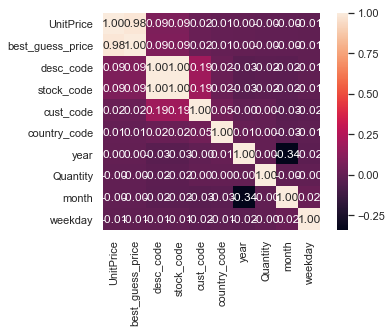

In [142]:
correlation_map = np.corrcoef(df_final[columns].values.T)
sns.set(font_scale=1.0)
heatmap = sns.heatmap(correlation_map, cbar=True, annot=True, square=True, fmt='.2f', yticklabels=columns.values, xticklabels=columns.values)

plt.show()

In [143]:
columns=columns.drop(['weekday', 'year', 'month'])

## PreProcessing and Feature Engg done, lets start modelling

In [144]:
X = df_final[columns]
Y = X['UnitPrice'].values
X = X.drop('UnitPrice', axis = 1).values

In [145]:
X_train, Y_train = X,Y

In [146]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor

**Try different baseline models to see which performs better**

In [147]:
import warnings
warnings.filterwarnings('ignore')
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()),('LR',LinearRegression())])))
pipelines.append(('ScaledLASSO', Pipeline([('Scaler', StandardScaler()),('LASSO', Lasso())])))
pipelines.append(('ScaledEN', Pipeline([('Scaler', StandardScaler()),('EN', ElasticNet())])))
pipelines.append(('ScaledKNN', Pipeline([('Scaler', StandardScaler()),('KNN', KNeighborsRegressor())])))
pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()),('CART', DecisionTreeRegressor())])))
pipelines.append(('ScaledGBM', Pipeline([('Scaler', StandardScaler()),('GBM', GradientBoostingRegressor())])))

results = []
names = []
for name, model in pipelines:
    kfold = KFold(n_splits=5, random_state=21)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='neg_mean_squared_error')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

ScaledLR: -27.249537 (31.986839)
ScaledLASSO: -28.365717 (32.424688)
ScaledEN: -121.260890 (60.449155)
ScaledKNN: -121.348607 (150.741406)
ScaledCART: -119.243372 (90.044697)
ScaledGBM: -130.983432 (117.120390)


**Since the best guess price we created is exactly same a unit price for the train set, LR model is highly overfitting the data giving best score. In any other scenario we would have gone with model giving best score (LR in this case), but to avoid overfitting and considering the need of generalising the prediction we will go with GBM regression which is not overfitting with the train set**

In [148]:
#Hyperparameter tuning
from sklearn.model_selection import GridSearchCV

scaler = RobustScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
rescaledX=X_train
# param_grid = dict(n_estimators=np.array([100,200]),learning_rate=np.array([0.1,0.2,0.3,0.5,1]),max_depth=np.array([3,6,9,15,20]),subsample=np.array([0.5,0.8,1]))
param_grid = dict(learning_rate=np.array([0.1,0.2,0.3,0.5,1]),max_depth=np.array([2,3,4,5,6]))
# param_grid = dict(max_depth=np.array([3,6,9,12,15]))

model = GradientBoostingRegressor(random_state=21,subsample=0.8,n_estimators=100)
kfold = KFold(n_splits=3, random_state=21)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=kfold,verbose=3)
grid_result = grid.fit(rescaledX, Y_train)

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV] learning_rate=0.1, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  learning_rate=0.1, max_depth=2, score=-38.93746755410354, total=  11.3s
[CV] learning_rate=0.1, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.7s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, score=-89.43877816759857, total=   9.1s
[CV] learning_rate=0.1, max_depth=2 ..................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   21.0s remaining:    0.0s


[CV]  learning_rate=0.1, max_depth=2, score=-249.0440794231096, total=   7.8s
[CV] learning_rate=0.1, max_depth=3 ..................................
[CV]  learning_rate=0.1, max_depth=3, score=-41.013725908911276, total=   9.4s
[CV] learning_rate=0.1, max_depth=3 ..................................
[CV]  learning_rate=0.1, max_depth=3, score=-104.26992761246467, total=  11.7s
[CV] learning_rate=0.1, max_depth=3 ..................................
[CV]  learning_rate=0.1, max_depth=3, score=-238.2298227211774, total=  11.2s
[CV] learning_rate=0.1, max_depth=4 ..................................
[CV]  learning_rate=0.1, max_depth=4, score=-41.96513024285151, total=  11.6s
[CV] learning_rate=0.1, max_depth=4 ..................................
[CV]  learning_rate=0.1, max_depth=4, score=-107.60458809254094, total=  11.4s
[CV] learning_rate=0.1, max_depth=4 ..................................
[CV]  learning_rate=0.1, max_depth=4, score=-253.67930054952825, total=  11.6s
[CV] learning_rate=0.1, 

[CV]  learning_rate=0.5, max_depth=6, score=-51.317677377995395, total=  17.3s
[CV] learning_rate=0.5, max_depth=6 ..................................
[CV]  learning_rate=0.5, max_depth=6, score=-105.20230942448897, total=  17.2s
[CV] learning_rate=0.5, max_depth=6 ..................................
[CV]  learning_rate=0.5, max_depth=6, score=-307.76224914079063, total=  18.1s
[CV] learning_rate=1.0, max_depth=2 ..................................
[CV]  learning_rate=1.0, max_depth=2, score=-63.43836791270473, total=   6.5s
[CV] learning_rate=1.0, max_depth=2 ..................................
[CV]  learning_rate=1.0, max_depth=2, score=-111.18242604947994, total=   7.9s
[CV] learning_rate=1.0, max_depth=2 ..................................
[CV]  learning_rate=1.0, max_depth=2, score=-427.2432215377894, total=   8.8s
[CV] learning_rate=1.0, max_depth=3 ..................................
[CV]  learning_rate=1.0, max_depth=3, score=-127.80622354369157, total=  10.4s
[CV] learning_rate=1.0,

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed: 16.4min finished


-125.806470 (89.547633) with: {'learning_rate': 0.1, 'max_depth': 2}
-127.837521 (82.219769) with: {'learning_rate': 0.1, 'max_depth': 3}
-134.416015 (88.486831) with: {'learning_rate': 0.1, 'max_depth': 4}
-134.386615 (90.884105) with: {'learning_rate': 0.1, 'max_depth': 5}
-133.315776 (89.000330) with: {'learning_rate': 0.1, 'max_depth': 6}
-119.803422 (79.256809) with: {'learning_rate': 0.2, 'max_depth': 2}
-132.264583 (84.231361) with: {'learning_rate': 0.2, 'max_depth': 3}
-133.709806 (90.692214) with: {'learning_rate': 0.2, 'max_depth': 4}
-144.710748 (102.086308) with: {'learning_rate': 0.2, 'max_depth': 5}
-137.843309 (91.744529) with: {'learning_rate': 0.2, 'max_depth': 6}
-143.447721 (110.631766) with: {'learning_rate': 0.3, 'max_depth': 2}
-129.521594 (84.924612) with: {'learning_rate': 0.3, 'max_depth': 3}
-139.157076 (89.239244) with: {'learning_rate': 0.3, 'max_depth': 4}
-134.456494 (82.212269) with: {'learning_rate': 0.3, 'max_depth': 5}
-147.890539 (102.690213) with: {

**Get predictions on test set**

In [149]:
X_test_final=test_final[columns.drop('UnitPrice')].values
X_test_final

array([[1.65000000e+00, 1.58100000e+03, 1.52300000e+03, 1.97200000e+03,
        1.25000000e+00, 3.00000000e+00],
       [1.25000000e+00, 1.02300000e+03, 9.93000000e+02, 8.62000000e+02,
        1.25000000e+00, 1.00000000e+00],
       [3.61666667e+00, 2.94900000e+03, 2.79700000e+03, 3.50800000e+03,
        1.25000000e+00, 3.60000000e+01],
       ...,
       [1.25000000e+00, 1.02300000e+03, 9.93000000e+02, 1.97200000e+03,
        1.25000000e+00, 6.00000000e+00],
       [3.95000000e+00, 2.87000000e+03, 2.73500000e+03, 8.62000000e+02,
        1.25000000e+00, 1.00000000e+00],
       [4.15000000e+00, 2.89500000e+03, 2.76000000e+03, 8.62000000e+02,
        1.25000000e+00, 3.00000000e+00]])

In [150]:
columns

Index(['UnitPrice', 'best_guess_price', 'desc_code', 'stock_code', 'cust_code',
       'country_code', 'Quantity'],
      dtype='object')

In [151]:
from sklearn.metrics import mean_squared_error

scaler = RobustScaler().fit(X_train)
rescaled_X_train = scaler.transform(X_train)
rescaled_X_train=X_train
model = GradientBoostingRegressor(random_state=21,n_estimators=100,max_depth=3,learning_rate=0.1)
model.fit(rescaled_X_train, Y_train)


rescaled_X_test = scaler.transform(X_test_final)
rescaled_X_test=X_test_final
predictions = model.predict(rescaled_X_test)
print(predictions)

[1.65036871 1.25213205 3.33818472 ... 1.25213205 3.89317145 4.18302073]


In [152]:
model

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=21, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [153]:
pred_final=predictions
pred_final

array([1.65036871, 1.25213205, 3.33818472, ..., 1.25213205, 3.89317145,
       4.18302073])

In [154]:
#Export predictions to check the results
pred_final=pd.DataFrame(pred_final,columns=['UnitPrice'])
pred_final.info()
pred_final.to_csv('submission_final.csv',index=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 122049 entries, 0 to 122048
Data columns (total 1 columns):
UnitPrice    122049 non-null float64
dtypes: float64(1)
memory usage: 953.6 KB


**The rmse score of predictions on test set was 29.3 which gave me final rank of 47  out of more than 5500 participants in the hackathon**